In [1]:
%reload_ext autoreload
%autoreload 2

from fastai import *
from fastai.vision import *
from pathlib import Path
import PIL
import cv2

from utils import *
from dark import *
from wrn4 import *

# from torch.utils.data.sampler import WeightedRandomSampler
from imba_sampler import ImbalancedDatasetSampler

torch.backends.cudnn.benchmark = False

In [2]:
MASKS = 'train.csv'

PATH = Path('./')
TRAIN = Path('train512/')
TEST = Path('test512/')
TRAIN_AUG = Path('../aug/train/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
seg_aug = pd.read_csv('../aug/augment.csv', header=None)
seg_aug.columns = seg.columns
sample_sub = pd.read_csv(PATH/SAMPLE)
train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)

classes = [str(l) for l in range(28)]

In [3]:
len(seg),len(seg_aug)

(31072, 68093)

In [4]:
df = pd.read_csv('aug_train.csv'); len(df)

99165

In [6]:
arch = models.resnet18

In [9]:
stats = ([0.08069, 0.05258, 0.05487], [0.13704,0.10145, 0.15313])
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_lighting=0.1, max_warp=0.4)

In [10]:
def get_data(sz=64, bs=64, pct=0.2, sample=5000):
#     sz, pct, bs = 64, 0.2, 64
    src = (ImageItemList.from_df(df=df, path=PATH, folder=TRAIN_AUG, suffix='.png')
           .random_split_by_pct(pct)
           .label_from_df(sep=' ', classes=classes)
           .add_test([TEST/(f+'.png') for f in test_names]))
    data = (src.transform(tfms, size=sz))
    #         .databunch(bs=bs).normalize(stats))

    test_ds = data.test
    train_ds, val_ds = data.train, data.valid
    datasets = [train_ds,val_ds, test_ds]
    sampler = ImbalancedDatasetSampler(datasets[0], num_samples=sample)
    train_dl = DataLoader(datasets[0], bs, sampler=sampler, num_workers=12)
    val_dl = DataLoader(datasets[1], 2*bs, False, num_workers=8)
    test_dl = DataLoader(datasets[2], 2*bs, False, num_workers=8)

    return ImageDataBunch(train_dl, val_dl, test_dl).normalize(stats)

In [11]:
def get_learner(data, focal=False, fp16=False):
    learn = create_cnn(data, arch, metrics=[accuracy_thresh, f1], 
               callback_fns=[partial(GradientClipping, clip=0.1), ShowGraph])
    if focal: learn.loss_func = FocalLoss()
    if fp16: learn.to_fp16();
#     learn.split((arch.layers[9],arch.layers[13]))  #Split for 444 model [11,20]
    return learn.mixup(stack_y=False)

# 256

In [12]:
data = get_data(256, 256, 0.1, sample=None)

In [13]:
learn = get_learner(data, focal=True, fp16=True)

In [14]:
learn.model = nn.DataParallel(learn.model)

In [15]:
lr = 1e-2

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,1.319237,1.063394,0.955624,0.091586
2,1.112446,0.931107,0.959661,0.186991
3,1.028160,0.870205,0.962067,0.224027
4,0.973064,0.834725,0.962849,0.271862
5,0.942036,0.810959,0.963900,0.282427
6,0.923280,0.808427,0.963994,0.293818


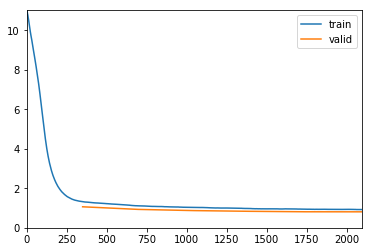

CPU times: user 7min 20s, sys: 2min 54s, total: 10min 15s
Wall time: 32min 8s


In [62]:
%time learn.fit_one_cycle(6, slice(lr))

In [16]:
learn.load('r18_final');

In [17]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,0.892324,0.951429,0.954802,0.288289
2,0.825756,0.784891,0.965273,0.271181
3,0.736576,0.819554,0.961901,0.383787
4,0.665784,0.689692,0.967959,0.448127
5,0.586907,0.553876,0.973863,0.551185
6,0.559643,0.533358,0.974785,0.561317


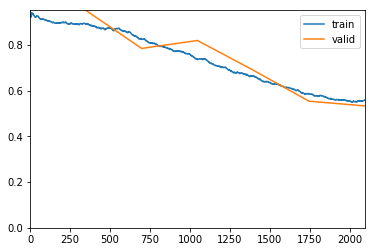

CPU times: user 11min 36s, sys: 4min 48s, total: 16min 25s
Wall time: 33min 34s


In [18]:
%time learn.fit_one_cycle(6, slice(lr/10, lr/3))

In [19]:
learn.save('r18_final');

In [20]:
learn.data.test_dl.add_tfm(to_half)
p,t = learn.get_preds(ds_type=DatasetType.Test)

# 512

In [30]:
data = get_data(512, 128, 0.1, sample=None)

In [31]:
learn.data = data

In [32]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,0.660661,0.618215,0.970924,0.473260
2,0.614485,0.564012,0.973398,0.499197
3,0.602358,0.562919,0.973099,0.509579
4,0.579965,0.548695,0.974086,0.518313


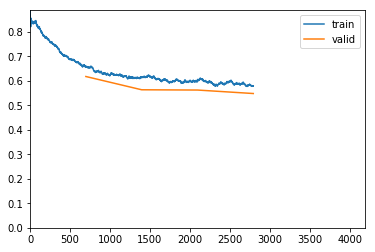

In [ ]:
%time learn.fit_one_cycle(6, slice(lr/3))

In [ ]:
learn.save('r18_512')

In [ ]:
learn.unfreeze()

In [ ]:
%time learn.fit_one_cycle(6, slice(lr/10, lr/5))

In [ ]:
learn.save('r18_512_u')

In [ ]:
learn.data.test_dl.add_tfm(to_half)
p,t = learn.get_preds(ds_type=DatasetType.Test)

# Sub File

In [ ]:
preds = to_np(p.sigmoid())  #Check if we are using focal loss or BCE.
threshold = 0.4 #ths
print(preds.shape)
classes = np.array(data.classes)
# classes = array(['16', '0', '7', '1', '2', '5', '18', '25', '23', '21', '24', '6', '11', '3', '12', '13', '14', '4', '20', '22',
#        '17', '19', '8', '9', '10', '26', '27', '15'], dtype='<U2')
res = np.array([" ".join(classes[(np.where(pp>threshold))])for pp in preds])

In [ ]:
classes

In [ ]:
frame = pd.DataFrame(np.array([test_names, res]).T, columns = ['Id','Predicted'])
frame.to_csv('protein_r18.csv', index=False)

In [ ]:
frame.head()